<h1>Naive analysis of A/2017 U1 magnitude observations</h1>

Data from MPC and https://projectpluto.com/temp/2017u1.htm

DISCLAIMER: this is experimental code. Results will be inconclusive due to unknown uncertainties in the input data.

Can something be said about the rotation period using the reported magnitudes?


In [1]:
%matplotlib inline 
%run functions.py


C:\Miniconda3\envs\astro\lib\site-packages\astropy\config\configuration.py:541: ConfigurationMissingWarning: Configuration defaults will be used due to OSError:22 on None
  warn(ConfigurationMissingWarning(msg))


In [2]:
asteroidHorizonsName = 'A/2017 U1'

mpcData = pd.read_fwf(
    'a2017u1_mpc.txt',
    header = None,
    widths = [13, 1, 1, 16, 12, 12, 10, 5, 1, 6, 3],
    usecols= [1, 2, 3, 7, 8, 9, 10],
    names = ['note1', 'note2', 'decimalDaytime', 'mag', 'band', 'blank', 'observatory']
)

In [3]:
#mpcData.to_csv('a2017u1.csv')

In [4]:
data = mpcData

data['time'] = data.decimalDaytime.apply(timeFromDecimalDaytime)
data['when'] = data.apply(lambda row: row.time.datetime.strftime('%Y-%b-%d %H:%M:%S'), axis=1)
data['timestamp'] = data.apply(lambda row: row.time.unix, axis=1)
data['date'] = data.apply(lambda row: row.time.datetime.strftime('%Y-%m-%d'), axis=1)


In [5]:
if False:
    dateList = data.date.unique()
    intervals = getHorizonsIntervalsForDates(dateList)
    ephemerides = pd.DataFrame()

    for interval in intervals:
        ephemerides = pd.concat([ephemerides,
            getReferenceMagnitudesFromHorizons(asteroidHorizonsName, interval[0], interval[1])
            ])
        
ephemerides = pd.read_fwf(
    'A2017U1_horizons.txt',
    widths=[22, 25, 6, 19, 10, 9, 5, 6],
    usecols=[0, 2],
    names=['date', 'APmag'])

def APmagFromEphemerides(eph):
    row = ephemerides.loc[ephemerides['date'] == (eph[0:15] + '00')].iloc[0]
    return float(row.APmag)

data['APmag'] = data.apply(lambda row: APmagFromEphemerides(row.when), axis=1)
data['magDelta'] = data.apply(lambda row: row.mag - row.APmag, axis=1)

In [6]:
relevantObservations = data

#relevantObservations = data.loc[data['timestamp'] > 1.508406e+09]
#relevantObservations.reset_index(inplace=True)
#relevantObservations


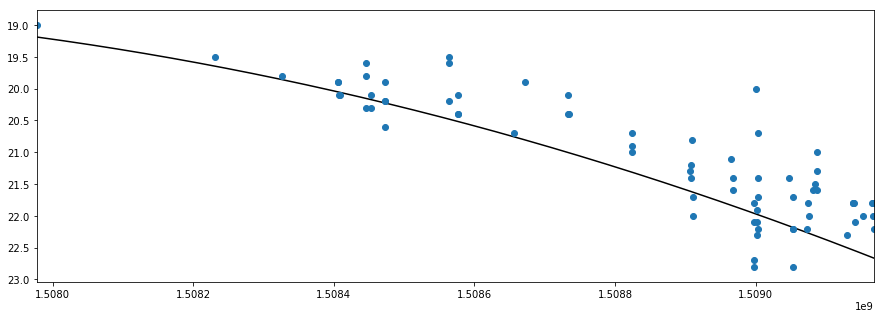

In [7]:
xs = [pd.to_datetime(d) for d in relevantObservations.when]

import numpy.polynomial.polynomial as poly
ts = relevantObservations.timestamp
coefs = poly.polyfit(ts, relevantObservations.APmag, 2)
x_new = np.linspace(ts[0], ts[len(ts) - 1], num=len(ts)*10)
ffit = poly.Polynomial(coefs)


plt.rcParams['figure.figsize'] = (15, 5);
plt.plot(x_new, ffit(x_new),color='k',lw=1.5, zorder=1);
plt.scatter(ts, relevantObservations.mag, zorder=2);
plt.xlim(ts[0], ts[len(ts) - 1]);
plt.gca().invert_yaxis();


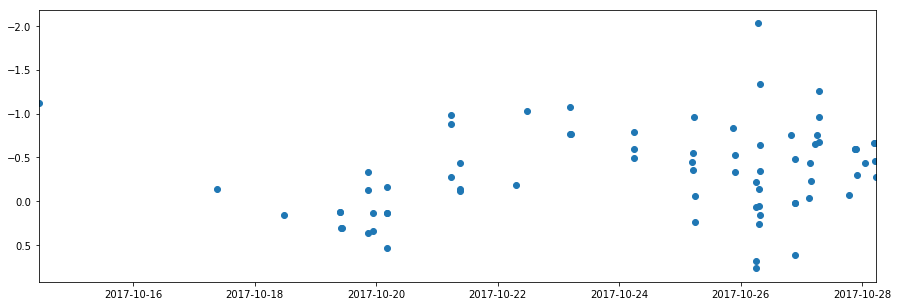

In [8]:
def plotMagDeltas(observations):
    xs = [pd.to_datetime(d) for d in relevantObservations.when]

    plt.rcParams['figure.figsize'] = (15, 5);
    plt.scatter(xs, observations.magDelta);
    plt.xlim(xs[0], xs[len(xs) - 1]);
    plt.gca().invert_yaxis();

plotMagDeltas(relevantObservations)

Best frequency =  0.0003023743949362368 1 / h
Best period =  3307.1583333333333 h


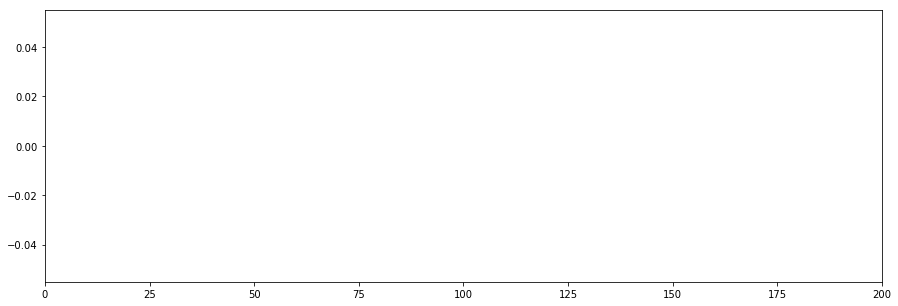

In [9]:
from astropy.stats import LombScargle
import astropy.units as u

def naiveLombScargle(observations):
    a = observations.timestamp.values
    startTimestamp = datetime.fromtimestamp(a[0])
    a = [((datetime.fromtimestamp(x)-startTimestamp).total_seconds() / 3600) for x in a]
    a = a * u.hour
    b = observations.magDelta.values
    freq, power = LombScargle(a, b).autopower()

    plt.rcParams['figure.figsize'] = (15, 5);
    plt.figure();
    plt.plot(1/freq, power);
    plt.xlim(0,200);

    best_frequency = freq[np.argmax(power)]

    print('Best frequency = ', best_frequency)
    print('Best period = ', 1/best_frequency)
    
    #t_fit = np.linspace(0*u.hour,1000*u.hour)
    #y_fit = LombScargle(a, b).model(t_fit, best_frequency)
    
    #plt.plot(y_fit);
    
naiveLombScargle(relevantObservations)

Best frequency =  0.4064591181550182 1 / h
Best period =  2.4602720306513413 h


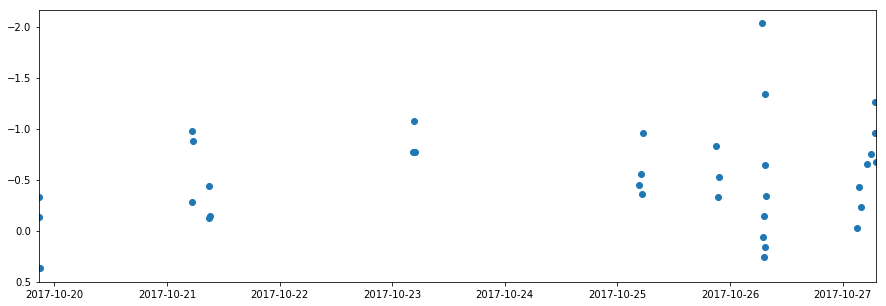

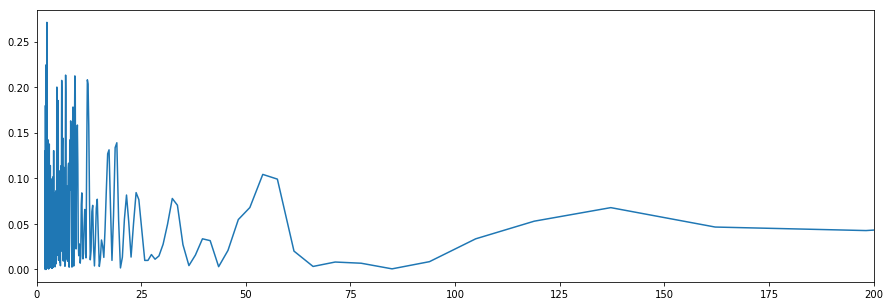

In [10]:
relevantObservations = data[(data.band == 'R')]
plotMagDeltas(relevantObservations)
naiveLombScargle(relevantObservations)


Best frequency =  0.1182283884200686 1 / h
Best period =  8.458205456095481 h


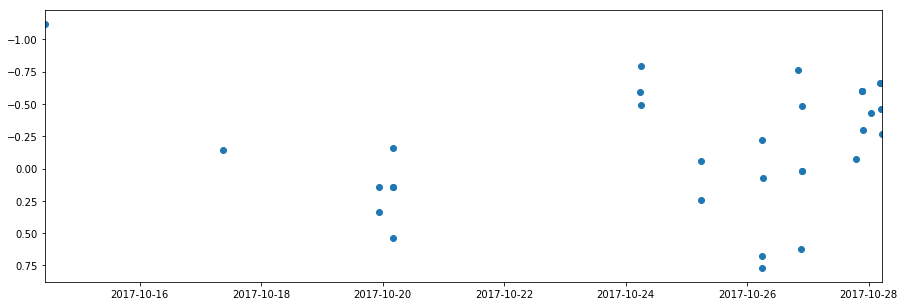

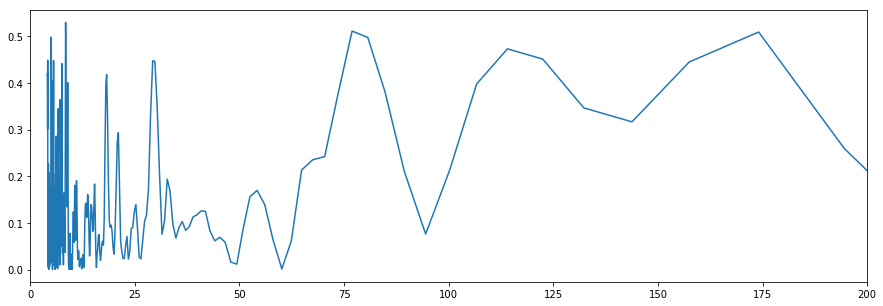

In [11]:
relevantObservations = data[(data.band == 'G')]
plotMagDeltas(relevantObservations)
naiveLombScargle(relevantObservations)

Best frequency =  0.259799185633989 1 / h
Best period =  3.8491267690454682 h


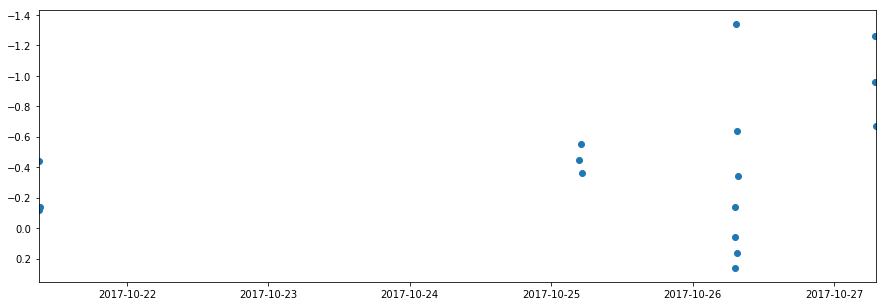

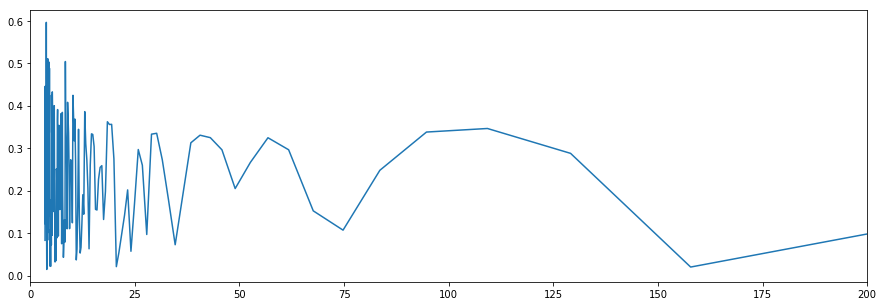

In [12]:
relevantObservations = data[(data.band == 'R') & (data.observatory == '926')]
plotMagDeltas(relevantObservations)
naiveLombScargle(relevantObservations)